# Number of gates study

This is an experimental analysis of the number of gates based on the size of the problem. First we test it with the exact rotation, then with the Chebyshev approximation. We get the total number of gates, but one of the advantages of QC is that you can run multiple gates simultaneously. To have that into consideration, we can introduce a rescaling factor. Most times, you can perform 2 gates at the same time, so the scaling factor would be ($\lambda=\frac{1}{1.5}\approx0.667$)

- Exact rotation

In [1]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from hhl_functions import *

In [2]:
gates={}
for i in range(4):
    size = 2**(i+1)
    vector = np.array([1]*size)
    matrix = tridiag_matrix(2,-1,size)
    hhl = HHL(matrix,vector,flag=True)
    count = hhl.qc.decompose(reps=6).count_ops()
    tot_gates=-3
    for elem in count.items():
        tot_gates += elem[1]
    gates[size]=tot_gates
    print(f'Number of gates in circuit of size {size}: {tot_gates}')

Number of gates in circuit of size 2: 72
Number of gates in circuit of size 4: 2283
Number of gates in circuit of size 8: 68118
Number of gates in circuit of size 16: 711352


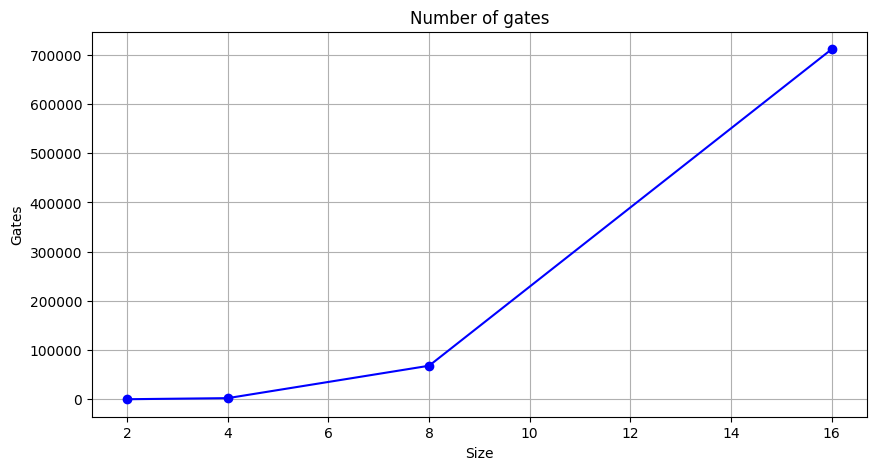

In [3]:
import matplotlib.pyplot as plt

keys = list(gates.keys())
values = list(gates.values())

plt.figure(figsize=(10, 5))
plt.plot(keys, values, marker='o', linestyle='-', color='blue')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.title('Number of gates')
plt.grid(True)
plt.show()

- Chebyshev piecewise function approximation

In [4]:
gates_est={}
for i in range(4):
    size = 2**(i+1)
    vector = np.array([1]*size)
    matrix = tridiag_matrix(2,-1,size)
    hhl = HHL(matrix,vector,flag=False)
    count = hhl.qc.decompose(reps=6).count_ops()
    tot_gates=-3
    for elem in count.items():
        tot_gates += elem[1]
    gates_est[size]=tot_gates
    print(f'Number of gates in circuit of size {size}: {tot_gates}')

Number of gates in circuit of size 2: 299
Number of gates in circuit of size 4: 6372
Number of gates in circuit of size 8: 99003
Number of gates in circuit of size 16: 846288


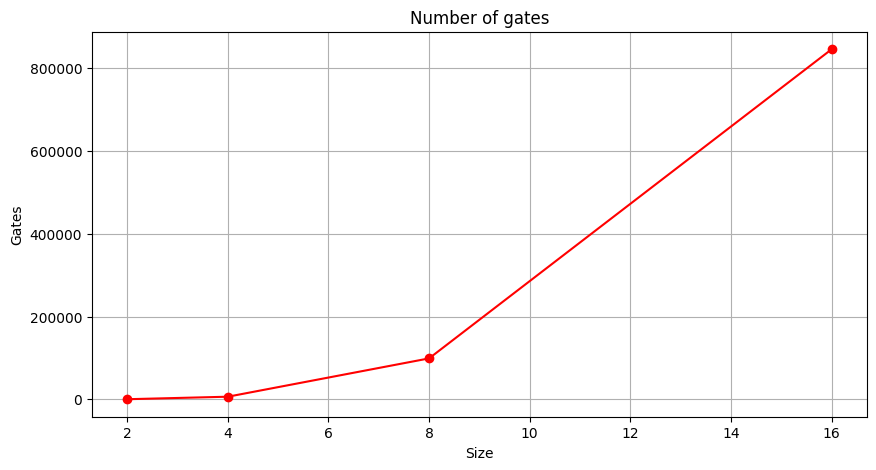

In [5]:
keys = list(gates_est.keys())
values = list(gates_est.values())

plt.figure(figsize=(10, 5))
plt.plot(keys, values, marker='o', linestyle='-', color='red')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.title('Number of gates')
plt.grid(True)
plt.show()

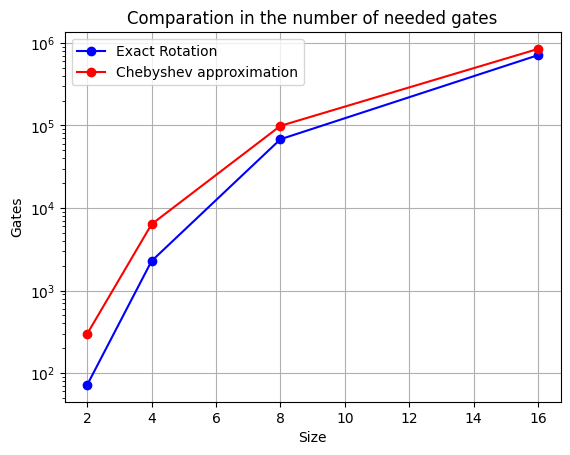

In [6]:
import matplotlib.pyplot as plt

keys_1 = list(gates.keys())
values_1 = list(gates.values())
keys = list(gates_est.keys())
values = list(gates_est.values())

# plt.figure(figsize=(10, 7))

plt.plot(keys_1, values_1, marker='o', linestyle='-', color='blue')
plt.plot(keys, values, marker='o', linestyle='-', color='red')
plt.yscale('log')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.title('Comparation in the number of needed gates')
plt.legend(['Exact Rotation','Chebyshev approximation'])
plt.grid(True)
plt.show()

- Number of circuit actions

In [7]:
scaling = 1/1.5
# Time used in each gate (in nanoseconds)
time_gate= 30
aprox_time_exact = np.array(list(gates.values()))*scaling
aprox_time_est = np.array(list(gates_est.values()))*scaling
diff = aprox_time_est-aprox_time_exact
diff_rel = diff/aprox_time_est
np.set_printoptions(suppress=True)
print(f'The number of actions of the exact circuit: {aprox_time_exact}')
print(f'The number of actions of the approx circuit: {aprox_time_est}')
print(f'Time exact circuit: {time_gate*aprox_time_exact/1000}')
print(f'Time approx circuit: {time_gate*aprox_time_est/1000}')
print(f'Difference: {diff}')
print(f'Relative difference: {diff_rel}')
print(f'Approximate time difference: {time_gate*diff/1000} us')

The number of actions of the exact circuit: [    48.           1522.          45412.         474234.66666667]
The number of actions of the approx circuit: [   199.33333333   4248.          66002.         564192.        ]
Time exact circuit: [    1.44    45.66  1362.36 14227.04]
Time approx circuit: [    5.98   127.44  1980.06 16925.76]
Difference: [  151.33333333  2726.         20590.         89957.33333333]
Relative difference: [0.75919732 0.64171375 0.31196024 0.15944454]
Approximate time difference: [   4.54   81.78  617.7  2698.72] us


## Type of doors

We can repeat the study but instead we can check how many of each gate the circuit has.

In [2]:
def count_gates(qiskit_circuit: QuantumCircuit):

    gates={'cx':0,'x':0,'h':0,'r':0,'rz':0,'rx':0,'ry':0,'u':0,'u2':0,'u1':0,'otro':0}
    
    for instruction in qiskit_circuit.data:
        gate, qargs, _ = instruction        
        if not gate.params or np.any(gate.params):
            if gate.name == 'cx':
                gates['cx']+=1
            elif gate.name == 'x':
                gates['x']+=1
            elif gate.name == 'h':
                gates['h']+=1
            elif gate.name == 'r':
                gates['r']+=1
            elif gate.name == 'rz':
                gates['rz']+=1
            elif gate.name == 'ry':
                gates['ry']+=1
            elif gate.name == 'rx':
                gates['rx']+=1
            elif gate.name == 'u3' or gate.name == 'u':
                theta, phi, lam = gate.params
                gates['u']+=1
            elif gate.name == 'u2':
                phi, lam = gate.params
                gates['u2']+=1
            elif gate.name == 'u1':
                gates['u1']+=1
            elif gate.name == 'barrier':
                gates['otro']+=1
                continue
            else:
                print(f"Gate {gate.name} is not supported in this script yet.")
    
    return gates

In [6]:
u1 = []
cx1 = []
for i in range(4):
    size = 2**(i+1)
    vector = np.array([1]*size)
    matrix = tridiag_matrix(2,-1,size)
    hhl = HHL(matrix,vector,flag=True)
    hhl.qc = prepare_circ(hhl.qc)
    gates = count_gates(hhl.qc)
    u1.append(gates['u'])
    cx1.append(gates['cx'])
    print(gates)

{'cx': 20, 'x': 0, 'h': 0, 'r': 0, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 47, 'u2': 0, 'u1': 0, 'otro': 3}
{'cx': 762, 'x': 0, 'h': 0, 'r': 0, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 1338, 'u2': 0, 'u1': 0, 'otro': 3}
{'cx': 23818, 'x': 0, 'h': 0, 'r': 4, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 39000, 'u2': 0, 'u1': 0, 'otro': 3}
{'cx': 253210, 'x': 0, 'h': 0, 'r': 4, 'rz': 0, 'rx': 0, 'ry': 1, 'u': 408095, 'u2': 0, 'u1': 0, 'otro': 3}


In [5]:
u2 = []
cx2 = []
for i in range(4):
    size = 2**(i+1)
    vector = np.array([1]*size)
    matrix = tridiag_matrix(2,-1,size)
    hhl = HHL(matrix,vector,flag=False)
    hhl.qc = prepare_circ(hhl.qc)
    gates = count_gates(hhl.qc)
    u2.append(gates['u'])
    cx2.append(gates['cx'])
    print(gates)

{'cx': 116, 'x': 0, 'h': 0, 'r': 0, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 164, 'u2': 4, 'u1': 14, 'otro': 3}
{'cx': 2426, 'x': 0, 'h': 0, 'r': 0, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 3641, 'u2': 12, 'u1': 42, 'otro': 3}
{'cx': 35722, 'x': 0, 'h': 0, 'r': 4, 'rz': 0, 'rx': 0, 'ry': 0, 'u': 52777, 'u2': 12, 'u1': 42, 'otro': 3}
{'cx': 306164, 'x': 0, 'h': 0, 'r': 4, 'rz': 0, 'rx': 0, 'ry': 1, 'u': 475307, 'u2': 36, 'u1': 126, 'otro': 3}


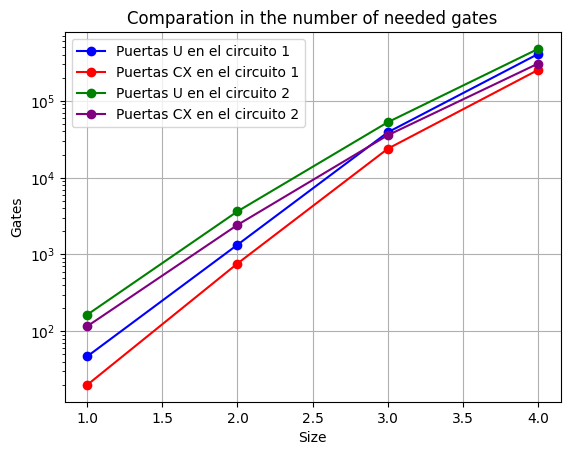

In [13]:
import matplotlib.pyplot as plt

x = np.arange(1,5,1)

# plt.figure(figsize=(10, 7))

plt.plot(x, u1, marker='o', linestyle='-', color='blue')
plt.plot(x, cx1, marker='o', linestyle='-', color='red')
plt.plot(x, u2, marker='o', linestyle='-', color='green')
plt.plot(x, cx2, marker='o', linestyle='-', color='purple')
plt.yscale('log')
plt.xlabel('Size')
plt.ylabel('Gates')
plt.title('Comparation in the number of needed gates')
plt.legend(['Puertas U en el circuito 1','Puertas CX en el circuito 1','Puertas U en el circuito 2','Puertas CX en el circuito 2'])
plt.grid(True)
plt.show()